In [3]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import datetime


In [4]:
ticker = "AAPL"
start_date = "2015-01-01"
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

df = yf.download(ticker, start=start_date, end=end_date)
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.288578,24.757332,23.848704,24.746224,212818400
2015-01-05,23.604332,24.137513,23.417720,24.057535,257142000
2015-01-06,23.606556,23.866481,23.244437,23.668760,263188400
2015-01-07,23.937576,24.037547,23.704309,23.815388,160423600
2015-01-08,24.857309,24.915071,24.148623,24.266369,237458000


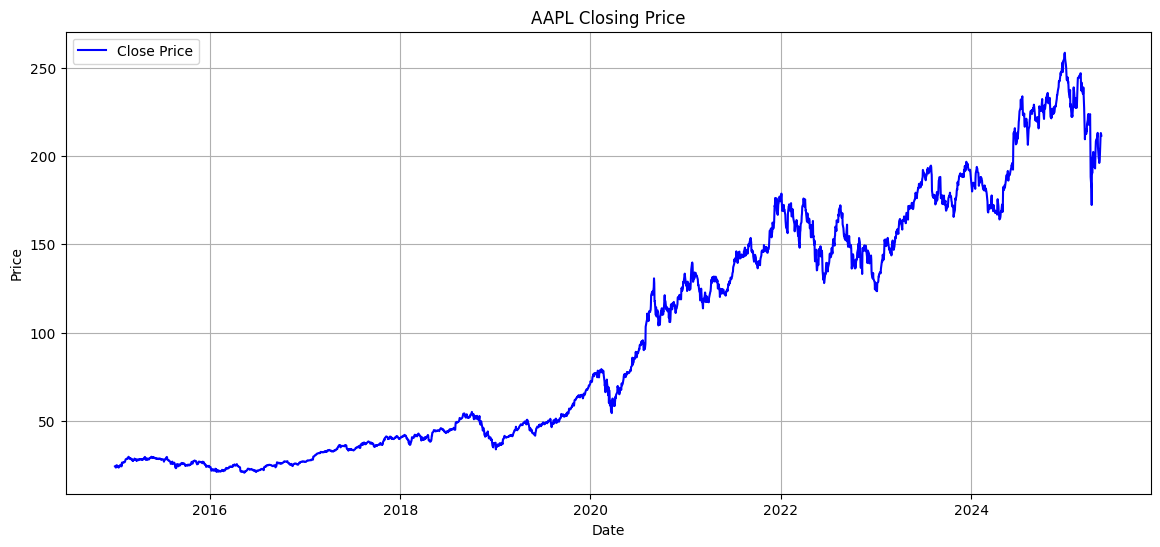

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title(f'{ticker} Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
data = df[['Close']].values

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)


In [7]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [8]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, verbose=1)


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0270 - val_loss: 0.0016
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.0017 - val_loss: 9.9470e-04
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.0012 - val_loss: 9.5480e-04
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0012 - val_loss: 9.7319e-04
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 8.9349e-04 - val_loss: 0.0019
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 9.7594e-04 - val_loss: 0.0020
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 9.3011e-04 - val_loss: 0.0025
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 9.1180e-04 - val_loss: 0.0019
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 8.8382e-04 - val_loss: 0.0026
Epoch 12/20
32/32 ━━━━━━━━━━━

In [10]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step


In [11]:
mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f'MSE: {mse:.4f}, MAE: {mae:.4f}')


MSE: 101.3155, MAE: 8.2238


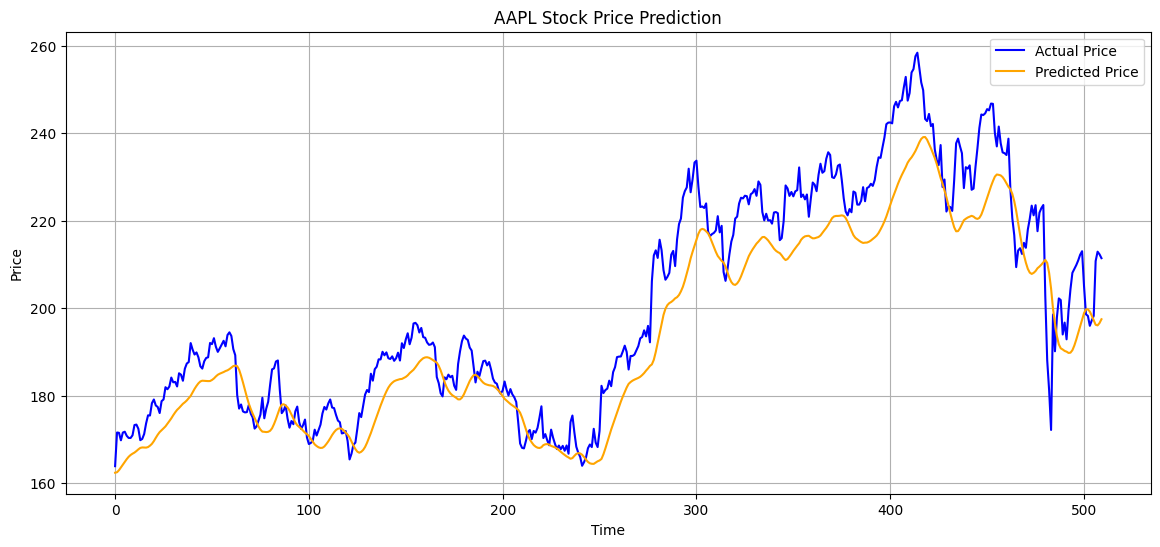

In [12]:
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price', color='orange')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


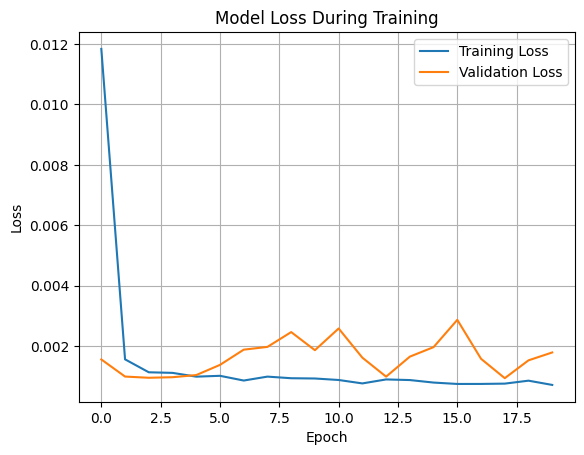

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
